In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from google.colab import drive

drive.mount('MyDrive')


Mounted at MyDrive


In [ ]:

import glob
train_data = glob.glob('MyDrive/MyDrive/Pneumonia_detection/chest_xray/train/**/*.jpeg')
test_data = glob.glob('MyDrive/MyDrive/Pneumonia_detection/chest_xray/test/**/*.jpeg')
val_data = glob.glob('MyDrive/MyDrive/Pneumonia_detection/chest_xray/val/**/*.jpeg')

print("〰"*20)
print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [ ]:
DIR = "MyDrive/MyDrive/Pneumonia_detection/chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)
print("〰"*20)
print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print("〰"*20)

〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰
Total Pneumonia Images: 4273
Total Normal Images: 1583
〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰〰


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm
import albumentations as A
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

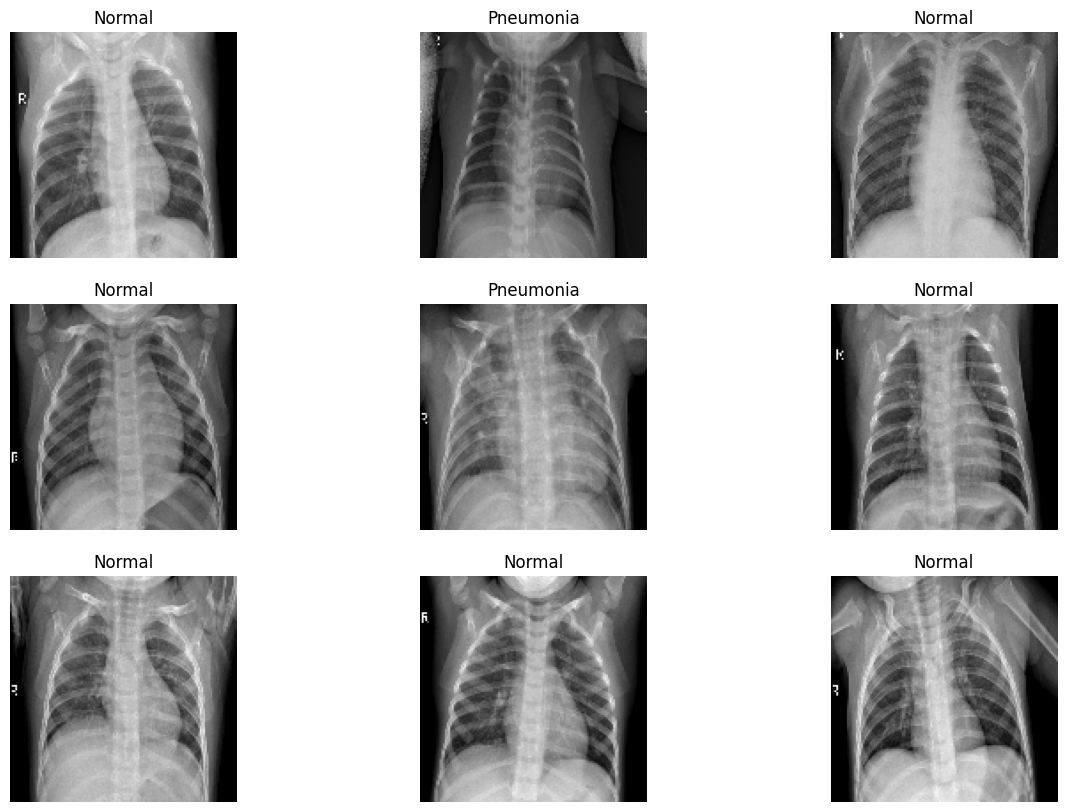

In [ ]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]
random.shuffle(images)
fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 3
for i in range(1, columns*rows +1):

    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)
    if images[i] in all_normal:
      plt.title('Normal')
    else:
      plt.title('Pneumonia')

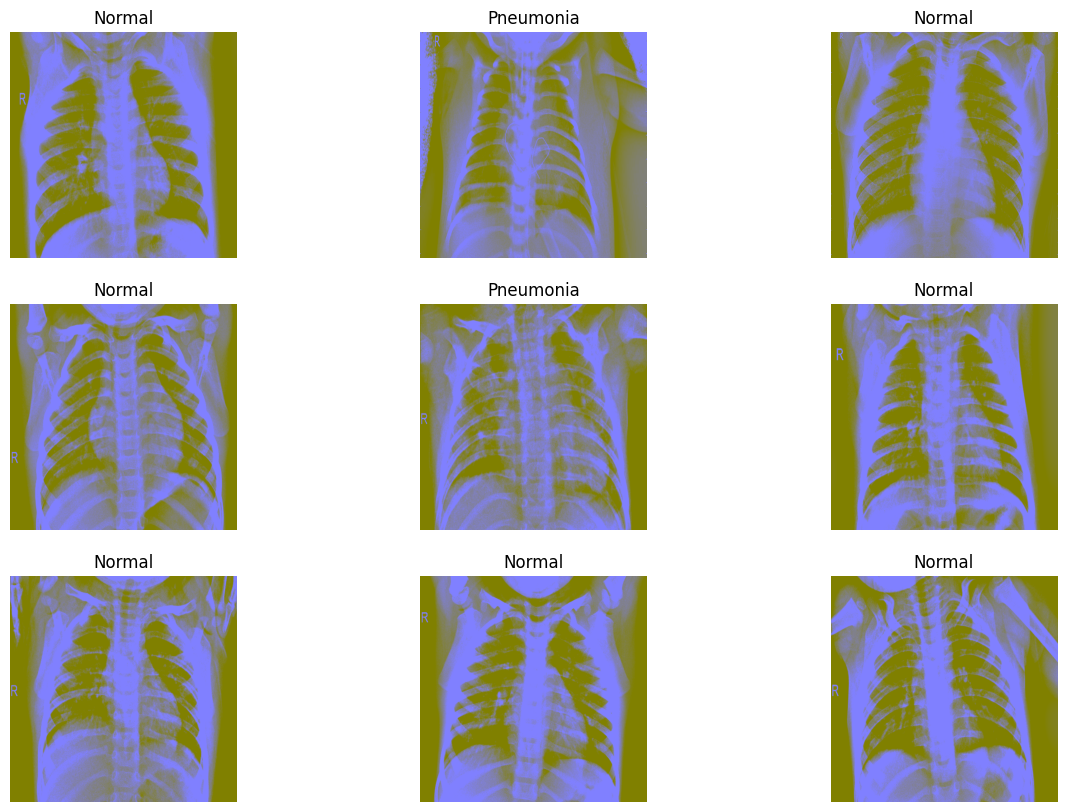

In [ ]:
#First, we convert the images to greyscale and then apply Gaussian blur to them.
fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)
    if images[i] in all_normal:
      plt.title('Normal')
    else:
      plt.title('Pneumonia')

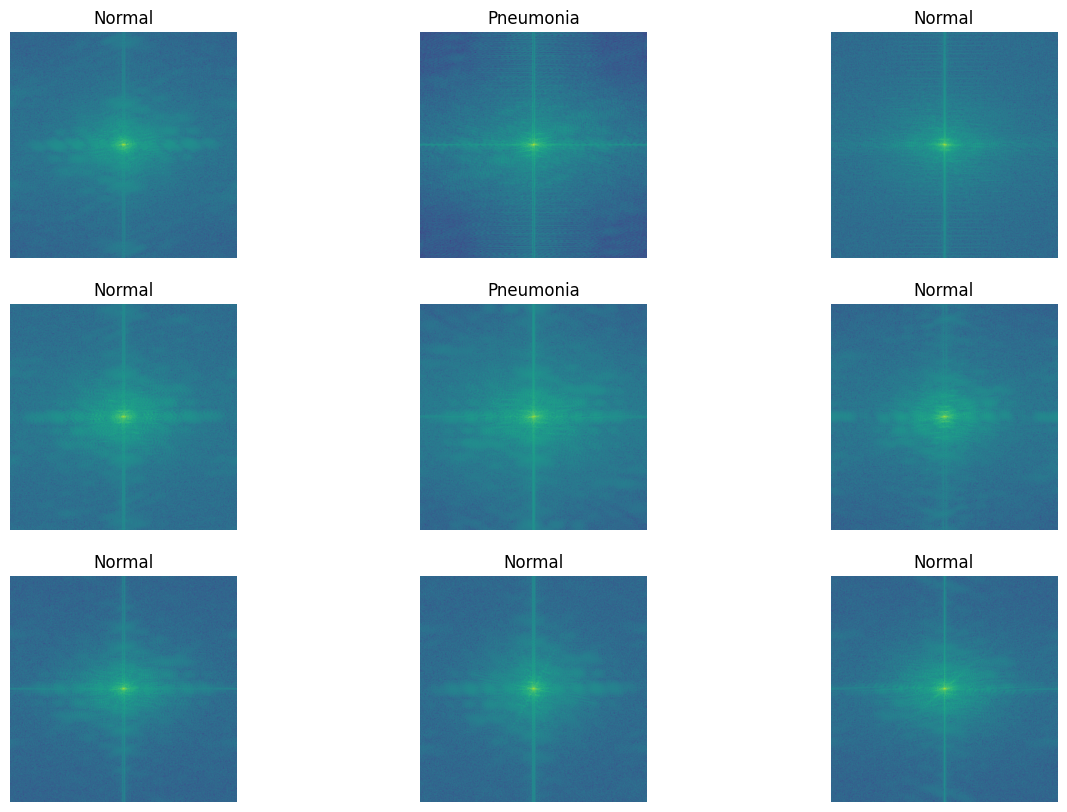

In [ ]:
#Now, let’s look into the pixel distributions. We’ll use the Fourier method for this.


fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)
    if images[i] in all_normal:
      plt.title('Normal')
    else:
      plt.title('Pneumonia')

All these images might look like a bunch of green dots on a blue background, but that’s not all. These images are basically magnitude spectrum which tells us where the majority of the growth is.

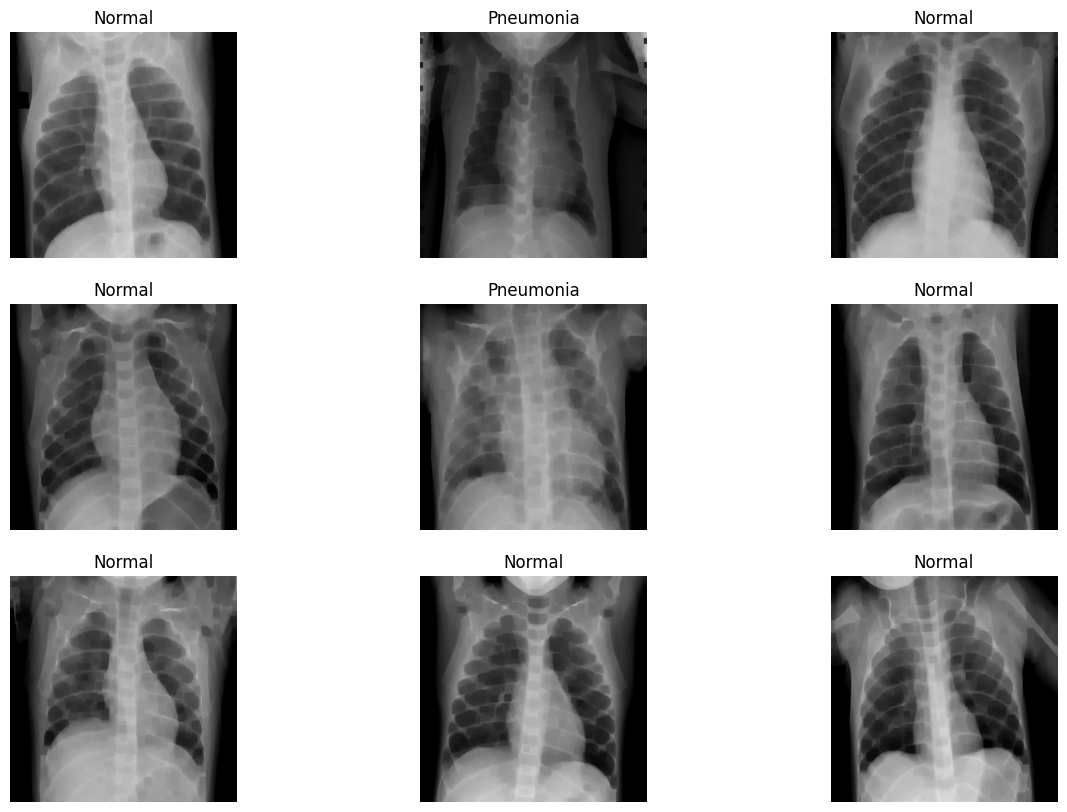

In [ ]:
#Image Erosion:


fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    img_dilate = cv2.dilate(img_erosion, kernel, iterations=3)
    edges = cv2.Canny(img_erosion, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)
    if images[i] in all_normal:
      plt.title('Normal')
    else:
      plt.title('Pneumonia')


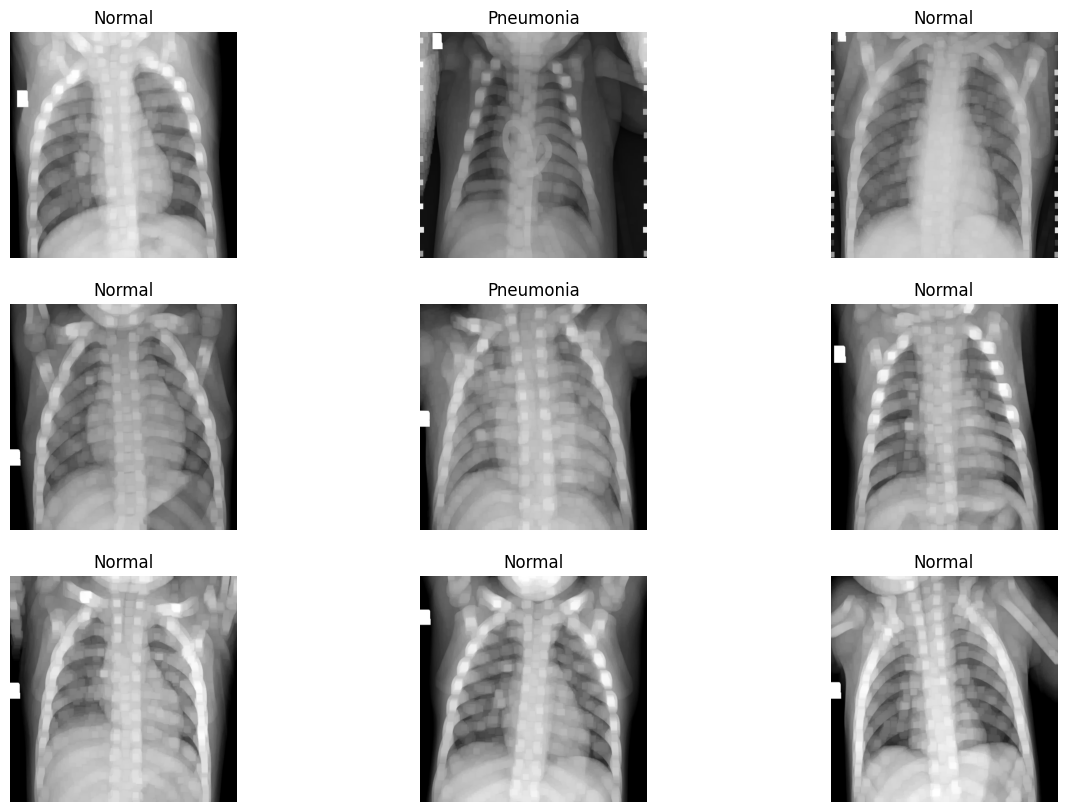

In [ ]:


#Dilation of Images


fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)
    if images[i] in all_normal:
      plt.title('Normal')
    else:
      plt.title('Pneumonia')

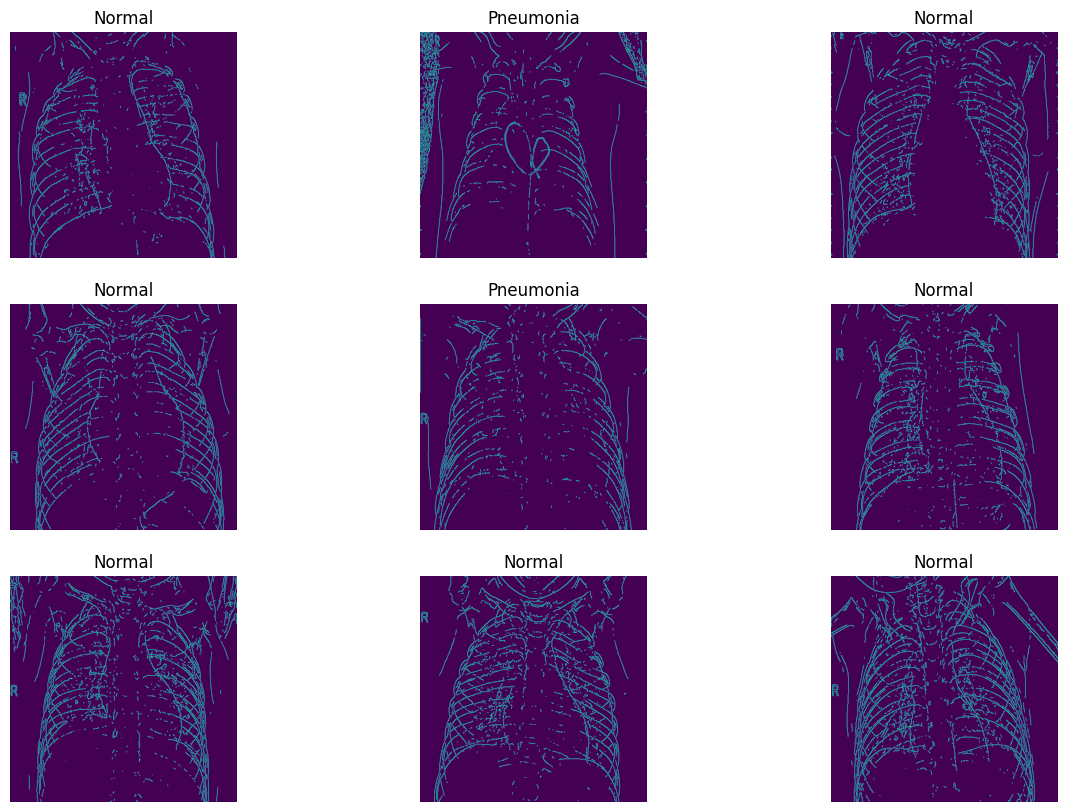

In [ ]:
#Now let’s use OpenCV’s Canny Edge Detection:
fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 3
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)
    if images[i] in all_normal:
      plt.title('Normal')
    else:
      plt.title('Pneumonia')

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=0.3,
    zoom_range=0.4
)
val_gen = ImageDataGenerator(
    rescale=1/255.,
)

In [ ]:
import os
import shutil

Train = train_gen.flow_from_directory(
    "MyDrive/MyDrive/Pneumonia_detection/chest_xray/train/",batch_size=16,
    target_size=(224, 224),#class_mode="binary"
)
val = train_gen.flow_from_directory(
    "MyDrive/MyDrive/Pneumonia_detection/chest_xray/test/",batch_size=8,
    target_size=(224, 224),#class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
X_test,Y_test = val.next()


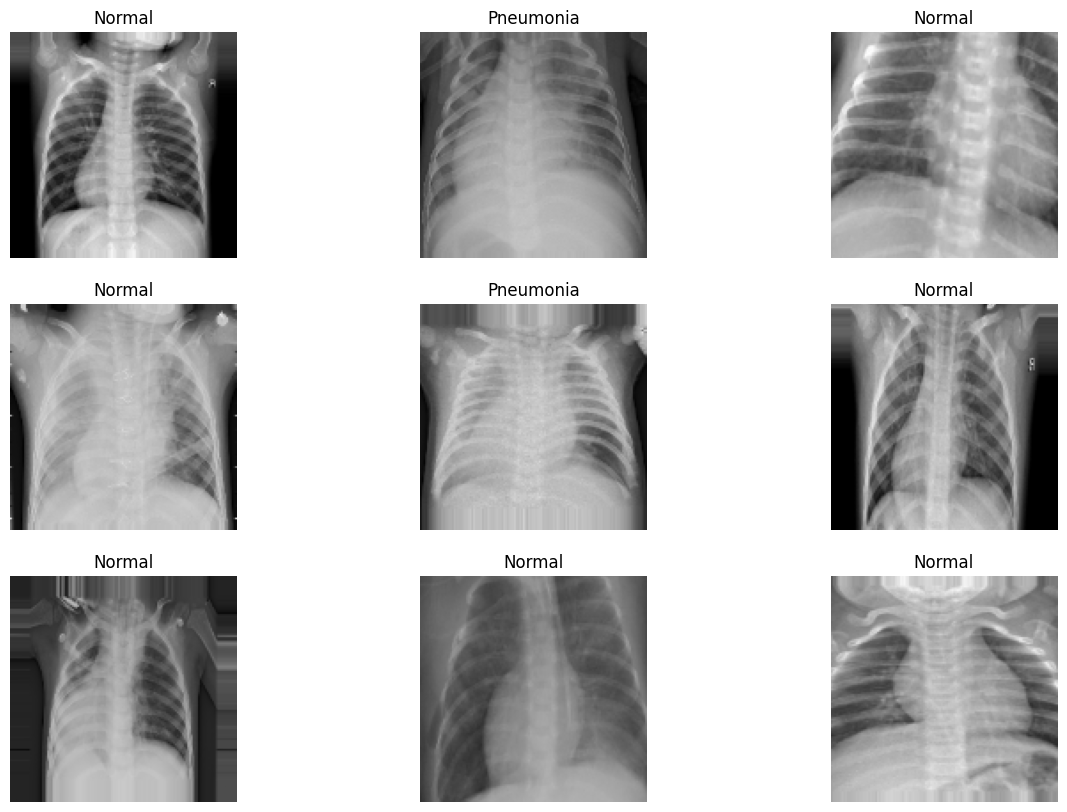

In [ ]:
from google.colab.patches import cv2_imshow
fig=plt.figure(figsize=(15, 10))
columns = 3; rows = 3
X_train, Y_train = Train.next()
for i in range(1, columns*rows +1):
    img = X_train[i]
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)
    if images[i] in all_normal:
      plt.title('Normal')
    else:
      plt.title('Pneumonia')

In [ ]:
from sklearn.linear_model import LogisticRegression

# Crear un objeto del modelo de regresión logística
lr_model = LogisticRegression(random_state=42)
# Aplanar los datos de imagen
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Crear un objeto del modelo de regresión logística
lr_model = LogisticRegression(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
lr_model.fit(X_train_flat, Y_train.argmax(axis=1))

# Predecir las clases del conjunto de prueba
y_pred = lr_model.predict(X_test_flat)

# Evaluar la precisión del modelo
accuracy = lr_model.score(X_test_flat, Y_test.argmax(axis=1))

print("Accuracy:", accuracy)

Accuracy: 0.625


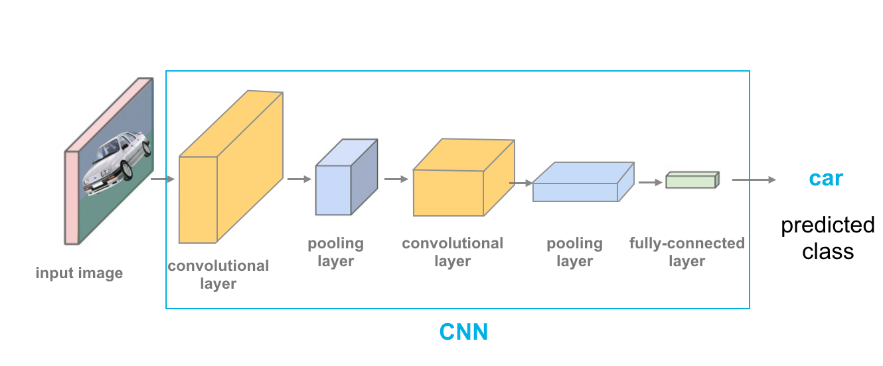

Now it’s time to actually build the neural network architecture. Let’s start with the input layer (input1). So this layer basically takes all the image samples in our X data. Hence we need to ensure that the first layer accepts the exact same shape as the image size.
Then, this input1 layer is connected to several convolution-pooling layer pairs before eventually being flattened and connected to dense layers. Notice that all hidden layers in the model are using the ReLU activation function due to the fact that ReLU is faster to compute compared to sigmoid, and thus, the training time required is shorter.

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [ ]:
## Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Now it’s time to train the model! Here we are going to use fit_generator() instead of fit() because we are going to take the train data from the train_gen object

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

history = model.fit_generator(Train,epochs=20,validation_data=val,steps_per_epoch=50,callbacks=[early_stopping_cb])


<ipython-input-19-c4cfe95ff149>:3: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
50/50 [==============================] - 303s 6s/step - loss: 0.5850 - accuracy: 0.7500 - val_loss: 0.6692 - val_accuracy: 0.6939
Epoch 2/20
50/50 [==============================] - 203s 4s/step - loss: 0.4472 - accuracy: 0.8000 - val_loss: 0.5724 - val_accuracy: 0.7452
Epoch 3/20
50/50 [==============================] - 174s 3s/step - loss: 0.4173 - accuracy: 0.8050 - val_loss: 0.4866 - val_accuracy: 0.7452
Epoch 4/20
50/50 [==============================] - 169s 3s/step - loss: 0.3733 - accuracy: 0.8413 - val_loss: 0.7361 - val_accuracy: 0.6971
Epoch 5/20
50/50 [==============================] - 169s 3s/step - loss: 0.3495 - accuracy: 0.8400 - val_loss: 0.5780 - val_accuracy: 0.7580
Epoch 6/20
50/50 [==============================] - 133s 3s/step - loss: 0.3229 - accuracy: 0.8600 - val_loss: 0.4986 - val_accuracy: 0.7564
Epoch 7/20
50/50 [==============================] - 128s 3s/step - loss: 0.3226 - accuracy: 0.8512 - val_loss: 0.4647 - val_accuracy: 0.7901
Epoch 8/20
50

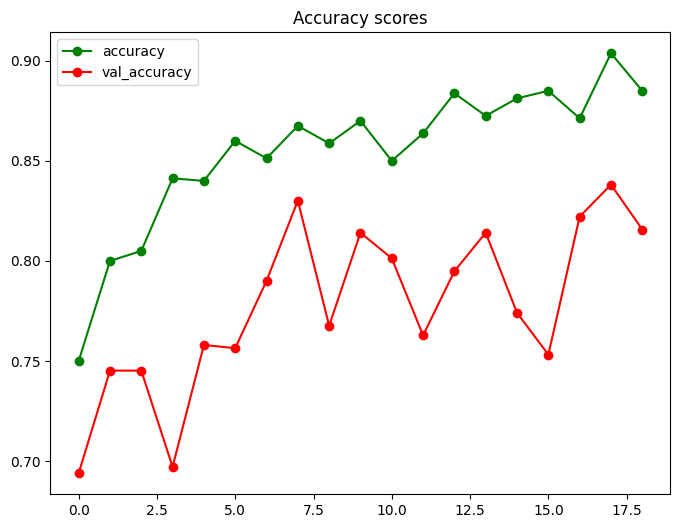

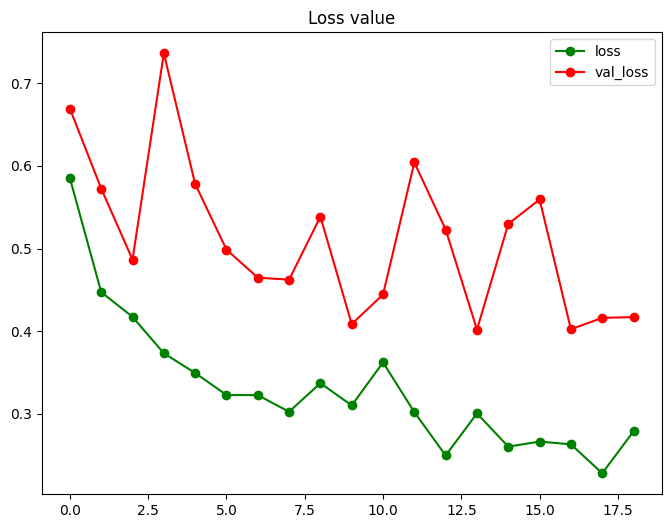

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'],'go-')
plt.plot(history.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'],'go-')
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()